# Measurement tutorial

### Initialization

In [1]:
# ensure relative imports are correctly imported
import sys
from configuration import *
sys.path.insert(0, '../qcore')

# Imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.QuantumMachine import QuantumMachine
from qm.qua import *

from instruments import LabBrick, MetaInstrument, Sa124, Stage, qm_config_builder
from measurements.routines.resonator_spectroscopy import ResonatorSpectroscopy
from measurements.routines.qubit_spectroscopy import QubitSpectroscopy
from measurements.routines.power_rabi import PowerRabi
from measurements.routines.qubit_T1 import QubitT1

In [2]:
# Staging
stage_yaml_file_name = 'stage.yaml'
stage_yaml_file_path = Path.cwd() / stage_yaml_file_name

stage = Stage.load(stage_yaml_file_path)

device = stage.device_A
qubit = stage.device_A.qubit
rr = stage.device_A.rr
lb_qubit = stage.lb_qubit
lb_rr = stage.lb_rr
sa = stage.sa

# start the qm
qmm = QuantumMachinesManager()
qm = qmm.open_qm(config)

Trying to initialize lb_qubit
Connnected to LabBrick 25331
Setting initial parameters...
Successfully set frequency to 4.1650000E+09
Successfully set power to +15
LabBrick is ready to use.
Trying to initialize lb_rr
Connnected to LabBrick 25335
Setting initial parameters...
Successfully set frequency to 8.7571000E+09
Successfully set power to +13
LabBrick is ready to use.
Trying to initialize sa, will take about 5s...
Connnected to SA124B 19184645
Configured sweep! Sweep info: 
{'start': '7.7501000E+09', 'center': '8.0000000E+09', 'span': '5.000E+08', 'sweep_length': 2500, 'rbw': '2.500E+05', 'ref_power': 0, 'bin_size': '2.000E+05'}
2021-04-27 16:12:52,089 - qm - INFO - Performing health check
2021-04-27 16:12:52,098 - qm - INFO - Health check passed


In [3]:
# Mixer tuning

rr_dcOffsetI = 0.00618044 
rr_dcOffsetQ = -0.00958788
rr_mixerGainCorrection = -0.16673524  
rr_mixerPhaseCorrection = 0.02148587

q_dcOffsetI = -0.00255501 
q_dcOffsetQ = -0.01036916
q_mixerGainCorrection = -0.18321374  
q_mixerPhaseCorrection = 0.11716296

# after this step we have tuned the IQ mixer.
qm.set_output_dc_offset_by_element("rr", "I", float(rr_dcOffsetI)) 
qm.set_output_dc_offset_by_element("rr", "Q", float(rr_dcOffsetQ))
qm.set_mixer_correction("mixer_rr", rr_IF, rr_LO, IQ_imbalance(rr_mixerGainCorrection, rr_mixerPhaseCorrection))
qm.set_output_dc_offset_by_element("qubit", "I", float(q_dcOffsetI)) 
qm.set_output_dc_offset_by_element("qubit", "Q", float(q_dcOffsetQ))
qm.set_mixer_correction("mixer_qubit", qubit_IF, qubit_LO, IQ_imbalance(rr_mixerGainCorrection, q_mixerPhaseCorrection))

### Resonator spectroscopy

In [4]:
# Number of iterations.
reps = 4000
# Wait time in clock cycles between iterations.
wait_time = int(200000)
# Measurement pulse frequency sweep range.
rr_f = [int(x) for x in np.arange(-51e6, -47.0e6, 0.01e6)]
# Measurement pulse amplitude scaling. Admits lists.
rr_ascale = 0.44
# Qubit pulse amplitude scaling. Admits lists. 
# Must be zero if qubit_pulse = None
qubit_ascale = 0.0
# Contains a string defining qubit operation. Doesn't play pulse if None.
qubit_pulse = None

RR_spec = ResonatorSpectroscopy('rr_spec', qm,        # Measurement nametag and QM object
                                reps, wait_time,      
                                rr_f, rr_ascale,      
                                qubit_ascale = qubit_ascale, 
                                qubit_pulse = qubit_pulse)      

In [5]:
# Adds you job to the queue. Running this line twice will erase the previous run and start from scratch.
RR_spec.queue_job()

Queueing new job.
2021-04-27 16:13:20,280 - qm - INFO - Flags: 
2021-04-27 16:13:20,281 - qm - INFO - Executing high level program
Job in execution. (ID: 1619511190271)


In [12]:
# Use this function to check the status of your job.
# It might be queued, in execution, concluded or not have been queued at all.
RR_spec.status()

# It is also possible to remove the job from the queue/stop its execution
# by issuing the following command:
# RR_spec.cancel_job()

Job was interrupted and erased.


Returning partial results of 1086 iterations (job not concluded).


(0.0, 4e-06)

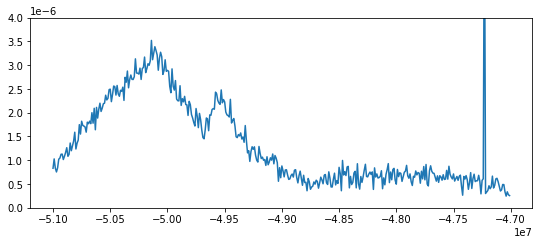

In [11]:
# It is possible to retrieve and analyze partial data. The program will print a warning
# if the data is not yet complete.
# Be careful only to compare data that has come from the same RR_spec.results() call,
# otherwise they may contain a different number of iterations.

# The results consist of a dictionary 
#    {'I_avg': I_results_averaged, 
#     'Q_avg': Q_results_averaged
#     'I': I_results
#     'Q': Q_results}.
# All dictionary values are ND numpy arrays. The averaged results corresponds to the
# running averages (see QM documentation on .average() in stream processing).

results = RR_spec.results()

# For resonator spectroscopy, the results arrays have 4 dimensions corresponding 
# to the variables:
# dim 1 - iterations. The last element [-1] is the most recent result available.
# dim 2 - qubit_ascale. If qubit pulse is disabled, it has a single element [0].
# dim 3 - rr_ascale.
# dim 4 - rr_f.

I_list = results['I_avg'][-1, 0, 0]
Q_list = results['Q_avg'][-1, 0, 0]
amps = np.abs(I_list + 1j*Q_list)
plt.figure(figsize=(9,3.5))
plt.plot(rr_f, amps)
plt.ylim([0, 4e-6])

### Qubit spectroscopy

In [13]:
# Number of iterations.
reps = 4000
# Wait time in clock cycles between iterations.
wait_time = int(200000)
# Measurement pulse frequency
rr_f = int(-50.2e6)
# Measurement pulse amplitude scaling.
rr_ascale = 0.44
# Qubit pulse frequency sweep range.
qubit_f = [int(x) for x in np.arange(-40e6, -60e6, -0.05e6)]
# Qubit pulse amplitude scaling. Admits lists.
qubit_ascale = [1.0]
# Contains a string defining qubit operation. Doesn't play pulse if None.
qubit_pulse = 'gaussian'

QU_spec = QubitSpectroscopy('qu_spec', qm,        # Measurement nametag and QM object
                            reps, wait_time,      
                            rr_f, rr_ascale,      
                            qubit_f, qubit_ascale, 
                            qubit_pulse) 

In [14]:
QU_spec.queue_job()

Queueing new job.
2021-04-27 16:19:32,708 - qm - INFO - Flags: 
2021-04-27 16:19:32,709 - qm - INFO - Executing high level program
Job in execution. (ID: 1619511562692)


Returning partial results of 85 iterations (job not concluded).


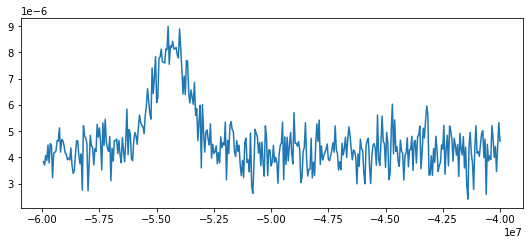

In [19]:
results = QU_spec.results()

# For qubit spectroscopy, the results arrays have 3 dimensions corresponding 
# to the variables:
# dim 1 - iterations. The last element [-1] is the most recent result available.
# dim 2 - qubit_ascale. If qubit pulse is disabled, it has a single element [0].
# dim 3 - qubit_f.

I_list = results['I_avg'][-1, 0]
Q_list = results['Q_avg'][-1, 0]
amps = np.abs(I_list + 1j*Q_list)
plt.figure(figsize=(9,3.5))
plt.plot(qubit_f, amps)

### Power Rabi

In [21]:
# Number of iterations.
reps = 4000
# Wait time in clock cycles between iterations.
wait_time = int(200000)
# Measurement pulse frequency
rr_f = int(-50.2e6)
# Measurement pulse amplitude scaling.
rr_ascale = 0.44
# Qubit pulse frequency.
qubit_f = int(-54.12e6)
# Qubit pulse amplitude scaling. Admits lists.
qubit_ascale = np.arange(-1.6, 1.6, 0.02)
# Contains a string defining qubit operation. Doesn't play pulse if None.
qubit_pulse = 'gaussian'

pw_rabi = PowerRabi('qu_spec', qm,        # Measurement nametag and QM object
                    reps, wait_time,      
                    rr_f, rr_ascale,      
                    qubit_f, qubit_ascale, 
                    qubit_pulse) 

In [22]:
pw_rabi.queue_job()

Queueing new job.
2021-04-27 16:20:43,211 - qm - INFO - Flags: 
2021-04-27 16:20:43,211 - qm - INFO - Executing high level program
Job in execution. (ID: 1619511633190)


Returning partial results of 96 iterations (job not concluded).


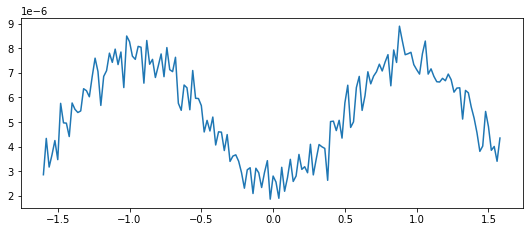

In [24]:
results = pw_rabi.results()

# For power rabi, the results arrays have 2 dimensions corresponding 
# to the variables:
# dim 1 - iterations. The last element [-1] is the most recent iteration available.
# dim 2 - qubit_ascale.

I_list = results['I_avg'][-1]
Q_list = results['Q_avg'][-1]
amps = np.abs(I_list + 1j*Q_list)
plt.figure(figsize=(9,3.5))
plt.plot(qubit_ascale, amps)

Returning partial results of 184 iterations (job not concluded).
Contrast / error std = 3.738


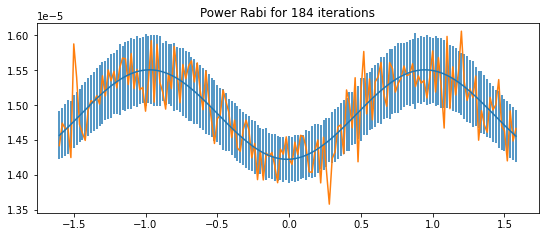

In [26]:
results = pw_rabi.results()

# Results above are not average, since we set average = False.
# We can use the iterations to make error bars.

from scipy.stats import norm
from scipy.optimize import curve_fit

I_list = results['I']
Q_list = results['Q']
amps = np.abs(I_list + 1j*Q_list)
n_iterations = len(amps)

# Fitting iterations to gaussian and retrieving the standard deviation
amps_std = [norm.fit(amps[:, i])[1] for i in range(len(qubit_ascale))] 
# amps_std holds the standard deviation of the error. The standard deviation
# of the error average must contain a 1/sqrt(reps) factor
amps_std = amps_std/np.sqrt(n_iterations)

# Averaging iterations
amps = np.average(amps, axis = 0)

# Fitting average to a cosine
guess_f = np.pi
guess_a = (max(amps) - min(amps))/2
guess_phase = np.pi
guess_offset = np.mean(amps)
p0 = [guess_f, guess_a, guess_phase, guess_offset]

def cos(x, freq, amplitude, phase, offset):
    return np.cos(x * freq + phase) * amplitude + offset

fit = curve_fit(cos, qubit_ascale, amps, p0 = p0)

# Signal-to-noise ratio for qubit state readout (contrast/sigma)
contrast = float(2*fit[0][1])
sigma = float(amps_std[0])
print('Contrast / error std = %.3f' % (contrast/sigma))

plt.figure(figsize=(9,3.5))
plt.errorbar(qubit_ascale, [cos(a, *fit[0]) for a in qubit_ascale], yerr=amps_std)
plt.plot(qubit_ascale, amps)
plt.title('Power Rabi for %d iterations' % n_iterations)
plt.show()

### Qubit T1

In [28]:
# Number of iterations.
reps = 4000
# Wait time in clock cycles between iterations.
wait_time = int(200000)
# Time the qubit is allowed to relax before measurement in clock cicles. Accepts lists.
tau = [int(x) for x in np.arange(24, 50000, 1000)]
# Measurement pulse frequency
rr_f = int(-50.2e6)
# Measurement pulse amplitude scaling.
rr_ascale = 0.44
# Qubit pulse frequency.
qubit_f = int(-54.12e6)
# Qubit pulse amplitude scaling.
qubit_ascale = 1.0
# Contains a string defining qubit operation. Doesn't play pulse if None.
qubit_pulse = 'gaussian'

qubit_t1 = QubitT1('qu_spec', qm,        # Measurement nametag and QM object
                   reps, wait_time,
                   tau,
                   rr_f, rr_ascale,      
                   qubit_f, qubit_ascale, 
                   qubit_pulse) 


In [29]:
qubit_t1.queue_job()

Queueing new job.
2021-04-27 16:21:34,097 - qm - INFO - Flags: 
2021-04-27 16:21:34,097 - qm - INFO - Executing high level program
Job in execution. (ID: 1619511684074)


Returning partial results of 2949 iterations (job not concluded).


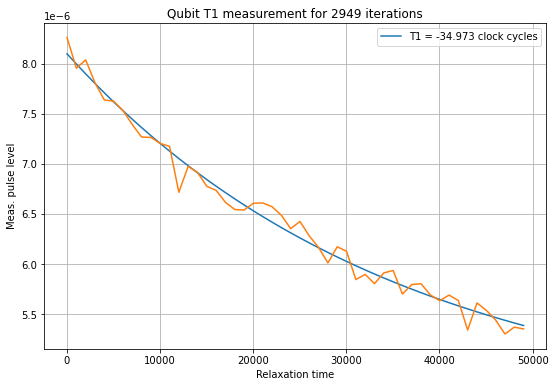

In [34]:
results = qubit_t1.results()

# For qubit T1 measurement, the results arrays have 2 dimensions corresponding 
# to the variables:
# dim 1 - iterations. The last element [-1] is the most recent iteration available.
# dim 2 - tau.

from scipy.optimize import curve_fit

I_list = results['I_avg'][-1]
Q_list = results['Q_avg'][-1]
amps = np.abs(I_list + 1j*Q_list)
n_iterations = len(results['I_avg'])

# Fitting data to an exponential curve
guess_a = 1
guess_rate = -10000
guess_offset = min(amps)
p0 = [guess_a, guess_rate, guess_offset]

def exp_curve(x, amplitude, rate, offset):
    return np.exp(x/rate)*amplitude + offset

fit = curve_fit(exp_curve, tau, amps, p0 = p0)

plt.figure(figsize=(9, 6))
plt.plot(tau, [exp_curve(a, *fit[0]) for a in tau], label = 'T1 = %.3f clock cycles' % (fit[0][1]/1000))
plt.plot(tau, amps)
plt.title('Qubit T1 measurement for %d iterations' % n_iterations)
plt.xlabel('Relaxation time')
plt.ylabel('Meas. pulse level')
plt.legend()
plt.grid()
plt.show()
